https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets


########### switches ################################

saveName='Oct11-2018_1'
saveFolder = saveName
saveplots=False
createSubmit = False
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"


############# Options/Args #########################

#columns to keep
col_to_keep = ['shop_id',
               'item_id',
               #'item_price',
               'item_category_id',
               'item_cnt_day',
              ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

agg_targ = {'item_cnt_day':'sum'}

col_targets=['shop_item_cnt_month',
             'shop_cnt_month',
             'item_cnt_month',
             'shop_item_cnt_month_diff(0-1)',
             'shop_cnt_month_diff(0-1)',
             'item_cnt_month_diff(0-1)']

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

opt = {'lag_length':3,
            'diff':True,
            'diffRel':False,
            'item_cat_count_feat':False,
            'target':target,
            'col_to_keep':col_to_keep,
            'groupby_list':groupby_list,
            'agg_dict':agg_dict,
            'agg_targ':agg_targ,
            'col_targets':col_targets,            
            } 
    
clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################


# create train/val/test set

In [2]:
Sets = Sets(**opt)
data = Sets.getData()
x_train, y_train = Sets.createTrainSet()
x_val, y_val = Sets.createValSet()
x_test = Sets.createTestSet()

lag_length: 3
diff: True
diffRel: False
item_cat_count_feat : False
target: shop_item_cnt_month
x_train.shape : (51460, 19)
y_train.shape : (51460,)
x_val.shape : (45755, 19)
y_val.shape : (45755,)
x_test.shape : (214200, 19)


In [3]:
#combine 2013+2014
# x_train  = pd.concat([x_train, x_val], ignore_index=True)
# y_train  = pd.concat([y_train, y_val], ignore_index=True)
# x_train.shape

# ShopID ItemID

In [4]:
items = data['items']
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
shops = data['shops']
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.shape

(22170, 3)

In [7]:
shops.shape

(60, 2)

In [8]:
nbins=20

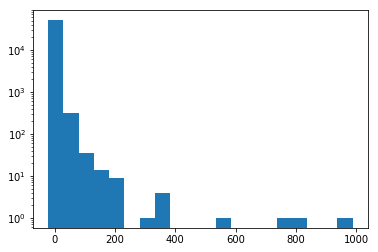

In [9]:
hist_y_train = plt.hist(y_train,nbins,log=True)
# counts = hist_y_train[0]
# bin_edges = hist_y_train[1]
# ut.hist_integrals(nbins,counts,bin_edges)

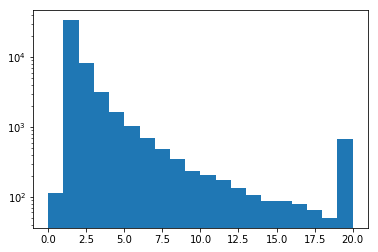

In [10]:
y_train_clip = np.clip(y_train,lowerClip,upperClip)
hist_y_train_clip = plt.hist(y_train_clip,nbins,log=True)
#hist_y_train_clip = sns.distplot(y_train_clip,bins=nbins,kde=False,hist_kws={'log':True})
#hist_y_train_clip.set_yscale('log')

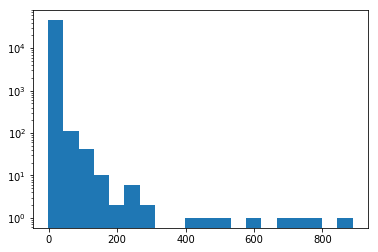

In [11]:
his_y_val = plt.hist(y_val,nbins,log=True)

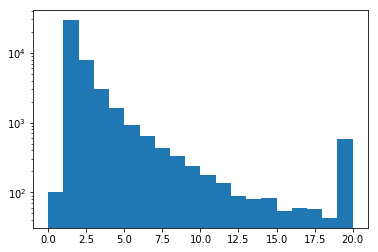

In [12]:
y_val_clip = np.clip(y_val,lowerClip,upperClip)
his_y_val_clip = plt.hist(y_val_clip,nbins,log=True)
#hist_y_val_clip = sns.distplot(y_train_clip,bins=nbins,kde=False,hist_kws={'log':True})
#hist_y_val_clip.set_yscale('log')

In [13]:
print 'Sum y_train before clip:',np.sum(y_train)
print 'Sum y_val before clip:', np.sum(y_val)
if(clipTarget):
    y_train=y_train_clip
    y_val=y_val_clip
print 'Sum y_train after clip:',np.sum(y_train)
print 'Sum y_val after clip:', np.sum(y_val)

Sum y_train before clip: 130009.0
Sum y_val before clip: 117845.0
Sum y_train after clip: 110388.0
Sum y_val after clip: 98404.0


In [14]:
x_train_ = x_train.drop(columns=['shop_item_id'])
x_val_ = x_val.drop(columns=['shop_item_id'])
x_test_ = x_test.drop(columns=['shop_item_id'])

# Model training

In [15]:
### Boosted Decision Tree (lightgbm)

import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

lgb_train = lgb.Dataset(x_train_, label=y_train)
lgb_test = lgb.Dataset(x_val_, label=y_val)

lgb_params = {
               'feature_fraction': .75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 1000
verbose_eval = num_boost_round/20
model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=200,
                  verbose_eval=verbose_eval)

#print 'evals_result = ',evals_result

Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 1.99852	eval's rmse: 2.22734
[100]	train's rmse: 1.78785	eval's rmse: 2.16319
[150]	train's rmse: 1.67905	eval's rmse: 2.16509
[200]	train's rmse: 1.6084	eval's rmse: 2.17639
[250]	train's rmse: 1.55835	eval's rmse: 2.19191
[300]	train's rmse: 1.52076	eval's rmse: 2.20812
Early stopping, best iteration is:
[134]	train's rmse: 1.70948	eval's rmse: 2.1617


In [176]:
# print('Plot metrics recorded during training...')
# ax = lgb.plot_metric(evals_result, metric='rmse')
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
# #plt.show()

# print('Plot feature importances...')
# ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
# ax.figure.set_size_inches(6.4*2,4.8*3)
# if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
# plt.show()

In [177]:
pred_lgb = model.predict(x_train_)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))

Training R-squared for LightGBM is 0.658834


In [178]:
pred_lgb = model.predict(x_val_)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Validation R-squared for LightGBM is 0.429254


# Predict with test data

In [19]:
pred = model.predict(x_test_)

In [20]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
pred_submit = pred

214200
[1.17701803 1.42091134 1.35244263 ... 1.1317638  1.13905354 1.20658296]
Sum pred: 300560.87825323775


In [21]:
#translate back to shop_item_cnt_month in needed
if target =='shop_item_cnt_month_diff(0-1)':  
    last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
    last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
    df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
    df_temp.fillna(0,inplace=True)
    df_temp.head()

    df_pred = pd.DataFrame(pred,columns=['y_pred_residual'])
    df_pred.head()

    df_pred['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred['y_pred_residual']
    df_pred.head()

    pred_submit = df_pred['y_pred'].values
    
# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit

[1.17701803 1.42091134 1.35244263 ... 1.1317638  1.13905354 1.20658296]


In [22]:
### adhoc scaling
#pred_submit = (pred_submit)*0.25 
#pred_submit = np.floor(pred_submit)
print pred_submit

[1.17701803 1.42091134 1.35244263 ... 1.1317638  1.13905354 1.20658296]


total sales pred: 300560.87825323775


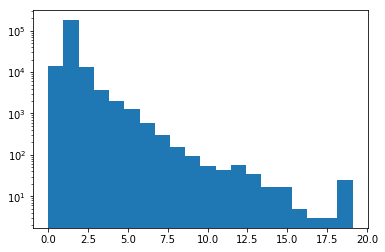

In [23]:
print 'total sales pred:',np.sum(pred_submit)
hist_pred = plt.hist(pred_submit,nbins,log=True)

# Validation with yearly trend (BDT)

total sales count from Oct11-2018_1 prediction: 300560.87825323775
total sales count from contant 0.5 prediction: 107100.0


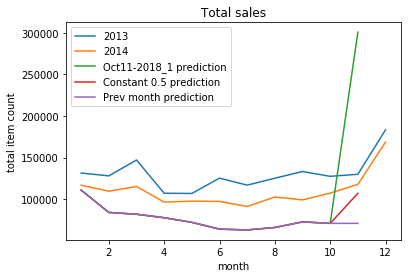

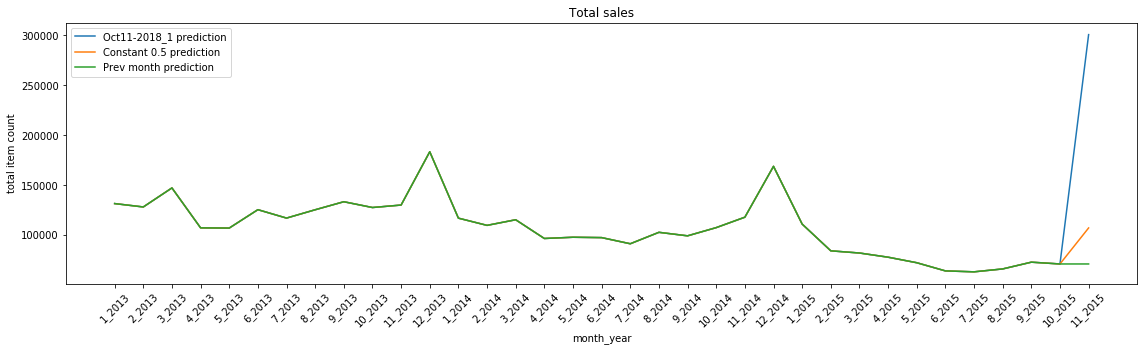

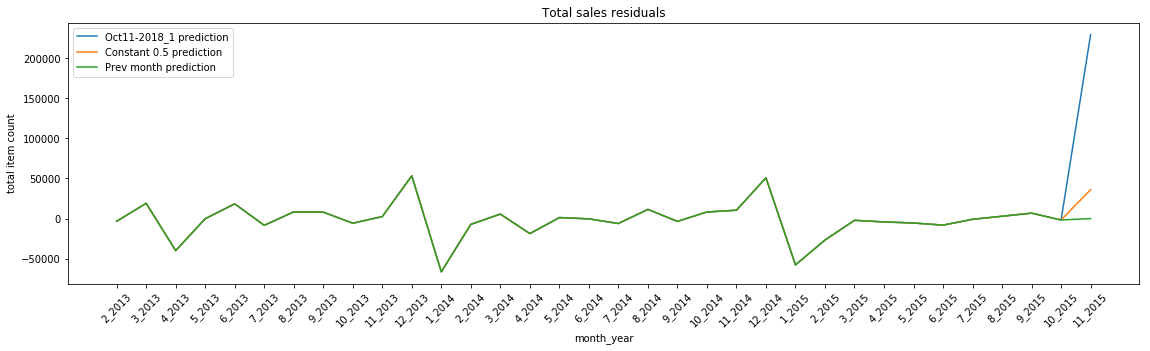

In [24]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

In [27]:
from scipy.sparse import coo_matrix
nitem = items.shape[0]
nshop = shops.shape[0]


(60, 22170) non-zero: 51460


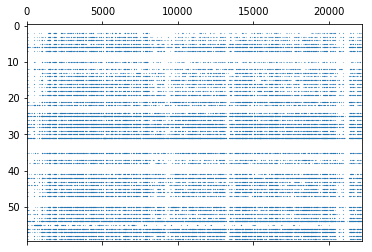

In [28]:
col_train = x_train['item_id'].values
row_train = x_train['shop_id'].values
data_train = y_train.values
coo_train = coo_matrix((data_train,(row_train,col_train)),shape=(nshop,nitem),dtype=np.int8)
print coo_train.shape, 'non-zero:',coo_train.nnz
fig_coo_train = plt.spy(coo_train,aspect='auto',precision=0.1, markersize=0.1)

(60, 22170) non-zero: 45755


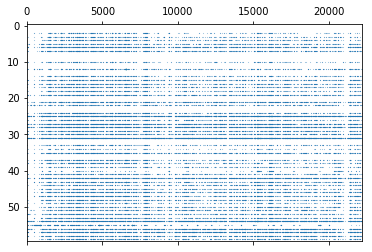

In [29]:
col_val = x_val['item_id'].values
row_val = x_val['shop_id'].values
data_val = y_val.values
coo_val = coo_matrix((data_val,(row_val,col_val)),shape=(nshop,nitem),dtype=np.int8)
print coo_val.shape,'non-zero:',coo_val.nnz
fig_coo_val = plt.spy(coo_val,aspect='auto',precision=0.1, markersize=0.1)

(60, 22170) non-zero: 214200


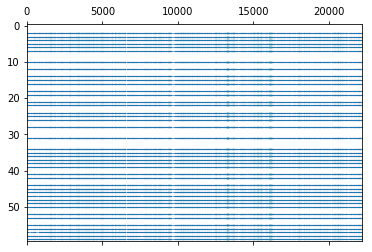

In [30]:
row_test = x_test['shop_id'].values
col_test = x_test['item_id'].values
data_test = y_test['item_cnt_month'].values
coo_test = coo_matrix((data_test,(row_test,col_test)),shape=(nshop,nitem),dtype=np.int8)
print coo_test.shape, 'non-zero:',coo_test.nnz
fig_test = plt.spy(coo_test,aspect='auto',precision=0.1, markersize=0.1)

In [31]:
csr_train = coo_train.tocsr()
csr_val = coo_val.tocsr()

In [32]:
csr_test = coo_test.tocsr()
csr_new = csr_test.multiply(csr_train+csr_val)

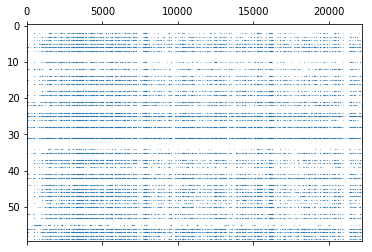

In [33]:
fig_new = plt.spy(csr_new,aspect='auto',precision=0.1, markersize=0.1)

# Prepare submission file

In [34]:
test_sorted = data['test'].sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 1.1770180313286953
submit[submit["ID"]==22987] =  1.1770180313286953


# Find shop_item_id that exists in all train/val/test

In [35]:
set_train = set(x_train['shop_item_id'].values) 
set_val = set(x_val['shop_item_id'].values)
set_test = set(x_test['shop_item_id'].values)
print 'train, val, test:',len(set_train),len(set_val),len(set_test)

train, val, test: 51460 45755 214200


In [36]:
print 'shop_item id existing in train-val-test:',len(set_test.intersection(set_train,set_val))
print 'shop item id existing in train(2013+2014) and test:',len(set_test.intersection(set_train.union(set_val)))

shop_item id existing in train-val-test: 4912
shop item id existing in train(2013+2014) and test: 29841


# Find items that exist in all train/val/test

In [37]:
item_all = data['items']['item_id'].values
item_train = set(x_train['item_id'].unique())
item_val = set(x_val['item_id'].unique())
item_test = set(x_test['item_id'].unique())
print 'ALL, train, val, test:',len(item_all),len(item_train),len(item_val),len(item_test)

ALL, train, val, test: 22170 8089 6322 5100


In [38]:
print 'item id existing in train-val-test:',len(item_test.intersection(item_train,item_val))
print 'item id existing in train(2013+2014) and test:',len(item_test.intersection(item_train.union(item_val)))

item id existing in train-val-test: 1189
item id existing in train(2013+2014) and test: 2716


# Incorporating **item price** as feature

In [111]:
sales_train_price = data['sales_train'][['shop_id','item_id','item_price']]

col_to_agg = {'item_price':{'item_price_min':'min','item_price_max':'max','item_price_mean':'mean'}}
sales_train_price_agg = data['sales_train'][['item_id','item_price']].groupby('item_id',as_index=False).agg(col_to_agg)

new_cols = [col[0] if col[-1] is '' else col[-1] for col in sales_train_price_agg.columns.values]
sales_train_price_agg.columns = new_cols

In [110]:
print 'total unique items in sales_train', len(data['sales_train'].item_id.unique())
sales_train_price_agg.shape

total unique items in sales_train 21807


(21807, 4)

In [109]:
pmin = sales_train_price_agg['item_price_min']
pmax = sales_train_price_agg['item_price_max']
pmean = sales_train_price_agg['item_price_mean']
items_stable_price = sales_train_price_agg[(pmin==pmax)]
print 'number of items in sales_train with stable price: ',items_stable_price.shape

number of items with stable price:  (5926, 4)


In [123]:
items_test = data['test'].item_id.unique()
print len(items_test)

5100


In [128]:
print 'no of item with stable price in sales train that exists in test:',len(set(items_stable_price.item_id.unique()).intersection(items_test))

no of item with stable price in sales train that exists in test 797


In [127]:
print 'no of item with price in sales train that exists in test:',len(set(sales_train_price_agg.item_id.unique()).intersection(items_test))

no of item with price in sales train that exists in test 4737


In [159]:
temp = sales_train_price[['item_id','item_price']]
print 'max priced item:'
temp[temp['item_price']==temp['item_price'].max()]

max priced item:


,item_id,item_price
1163158,6066,307980.0


In [160]:
print 'min priced item:'
temp[temp['item_price']==temp['item_price'].min()]

min priced item:


,item_id,item_price
484683,2973,-1.0


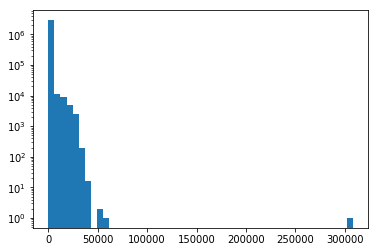

In [157]:
price = plt.hist(temp['item_price'],bins=50,log=True)

In [162]:
items[items['item_id']==6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [164]:
data['sales_train'][data['sales_train']['item_id']==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,Y_M
1163158,2013-12-13,11,12,6066,307980.0,1.0,75,2013,12,2013_12


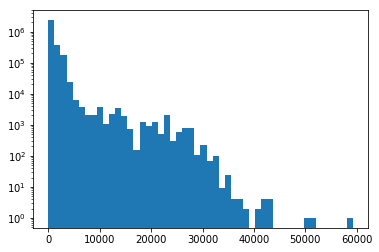

In [170]:
temp_1 = temp[temp['item_price']<300000]
hist = plt.hist(temp_1['item_price'],bins=50,log=True)

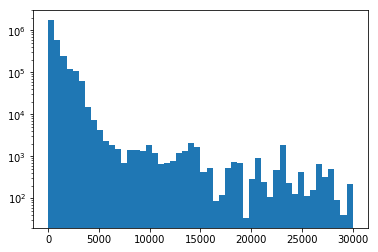

In [174]:
temp_2 = temp[temp['item_price']<30000]
hist = plt.hist(temp_1['item_price'],bins=50,log=True)